In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [2]:
name = "sps1"
filename_csv = f"data/{name}.csv"
filename_yaml = f"data/{name}.yaml"

In [3]:
# Load configuration
with open(filename_yaml, "r") as f:
    config = yaml.load(f, Loader=Loader)
config

{'date': datetime.date(2022, 7, 18),
 'vcc': 3.25,
 'r_load': 2194,
 'r_sense': 100,
 'gain': 100,
 'ref': 'unidirectional'}

In [4]:
meas = pd.read_csv("data/sps1.csv")
meas["I_nom"] = meas["V_in"] / config["r_load"] * 1e6
meas["I_calc"] = meas["V_current"] / config["r_sense"] / config["gain"] * 1e6
meas["V_2x_nom"] = meas["V_in"] * 2
meas

,V_in,V_2x,V_current,I_nom,I_calc,V_2x_nom
0,0.0175,0.0402,0.0777,7.976299,7.77,0.0350
1,0.0632,0.1320,0.2750,28.805834,27.50,0.1264
2,0.1010,0.2060,0.4370,46.034640,43.70,0.2020
3,0.1460,0.2980,0.6350,66.545123,63.50,0.2920
4,0.2050,0.4140,0.8870,93.436645,88.70,0.4100
5,0.2520,0.5100,1.0900,114.858706,109.00,0.5040
6,0.3080,0.6220,1.3400,140.382862,134.00,0.6160
7,0.3480,0.7010,1.5100,158.614403,151.00,0.6960
8,0.3880,0.7800,1.6800,176.845943,168.00,0.7760
9,0.4450,0.8950,1.9300,202.825889,193.00,0.8900


In [5]:
I_linreg = stats.linregress(meas["I_calc"], meas["I_nom"])
meas["I_fit"] = I_linreg.intercept + meas["I_calc"] * I_linreg.slope
I_mae_pre = abs(meas["I_calc"] - meas["I_nom"]).sum()/len(meas)
I_mae_post = abs(meas["I_nom"] - meas["I_fit"]).sum()/len(meas)

V_linreg = stats.linregress(meas["V_2x"], meas["V_2x_nom"])
meas["V_fit"] = V_linreg.intercept + meas["V_2x"] * V_linreg.slope
V_mae_pre = abs(meas["V_2x_nom"] - meas["V_2x"]).sum() / len(meas)
V_mae_post = abs(meas["V_2x_nom"] - meas["V_fit"]).sum() / len(meas)

print(I_mae_pre)
print(I_mae_post)

print(V_mae_pre*1000)
print(V_mae_post*1000)

8.481455674567005
0.21540811305053548
4.925000000000002
1.4210833329868486


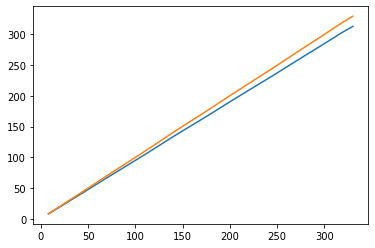

In [6]:
fig, ax = plt.subplots()
ax.plot(meas["I_nom"], meas["I_calc"])
ax.plot(meas["I_nom"], meas["I_fit"])

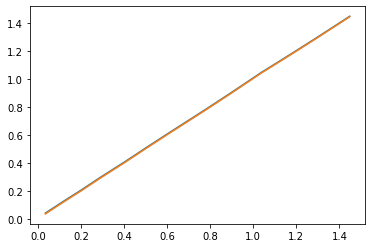

In [7]:
fig, ax = plt.subplots()
ax.plot(meas["V_2x_nom"], meas["V_2x"])
ax.plot(meas["V_2x_nom"], meas["V_fit"])